In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, validation_curve
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('error')


In [171]:
filepath = os.path.join(os.getcwd(), '../data/pre_PS.csv')
df = pd.read_csv(filepath)
df['Class'] = df['Class'].apply(lambda val: 0 if val == 'Benign' else 1)
df = shuffle(df, random_state = 1)

In [172]:
df.shape

(2285, 9)

In [173]:
X = df.drop('Class', axis=1)
y = df.loc[:,'Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
random_state=1, stratify=y)

In [174]:
print(f'X_train shape {X_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (1371, 8)
X_test shape (914, 8)
y_train shape (1371,)
y_test shape (914,)


In [175]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [227]:
# Checking the range of parameters
# degrees = np.arange(1,5)
C = [2,4,8,16,32, 64, 128, 256, 512]
train_accuracy = []
test_accuracy = []

for deg in C:
    #Knn classifier with k neighbors
    clf = SVC(kernel='poly', C=deg, random_state =1)
    #Fit the model
    clf.fit(X_train, y_train)
    #Compute accuracy on the training set and test set
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))
  

In [228]:
train_loss = []
validation_loss = []

for score in train_accuracy:
    train_loss.append((1 - score))

for score in test_accuracy:
    validation_loss.append((1 - score))

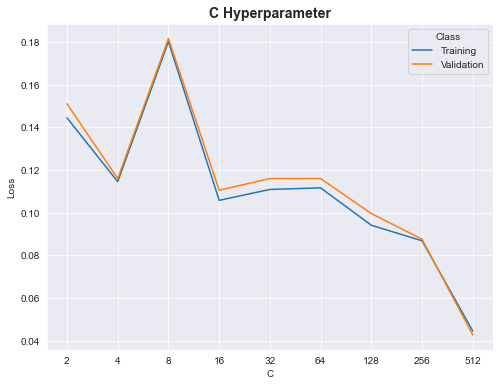

In [231]:
# # #Generate plot
x_ticks = [0,1,2,3,4,5,6,7, 8]
c_labels = [2,4,8,16,32, 64,128,256, 512]
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(8,6));
sns.lineplot(data=[train_loss, validation_loss], dashes=False, ax=ax)
ax.set_title('C Hyperparameter', fontsize=14, fontweight='bold');
ax.set(xlabel='C', ylabel='Loss');
ax.legend(title='Class', labels=['Training', 'Validation']);
plt.xticks(ticks=x_ticks, labels=c_labels);
# ax.set(xlim=(2,128));
# plt.savefig('../tuning/exp1_svmC.png', dpi=300)

In [148]:
# # tuning the hyperparameters

param_grid = {
    'kernel': ['poly'],
    'degree' : [1, 2, 3],
    'C': [2,4,8,16,32, 64, 128]
    
    }



grid = GridSearchCV(
    estimator = SVC(),
    param_grid= param_grid , 
    verbose =1, 
    cv=5,  
)
grid.fit(X_train,y_train)



Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [2, 4, 8, 16, 32, 62, 128], 'degree': [1, 2, 3],
                         'kernel': ['poly']},
             verbose=1)

In [149]:
print(f'Best paramater:  {grid.best_params_}')
print(f'Best score: {(grid.best_score_ * 100):.3f} %')

Best paramater:  {'C': 128, 'degree': 2, 'kernel': 'poly'}
Best score: 91.104 %


In [150]:
# fitting the model
# svm_ = SVC(kernel="poly", C=grid.best_params_["C"], gamma=grid.best_params_["gamma"], random_state=10)

In [151]:
# # fitting the model
svm_ = SVC(kernel="poly", C=grid.best_params_["C"], degree=grid.best_params_["degree"], random_state=10)

In [152]:
svm_

SVC(C=128, degree=2, kernel='poly', random_state=10)

In [153]:
# evaluating the models

In [154]:
def sensitivity(conf):
 return conf[1][1] / (conf[1][1] + conf[1][0])

def specificity(conf):
 return conf[0][0] / (conf[0][0] + conf[0][1])


In [155]:
def evaluate_model(X, y):

    train_accuracy = []
    test_accuracy = []
    sensitivity_scores = []
    specificity_scores = []
    confusion_matrix_scores = []
    precision_scores = []

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2) 
    for train, test in  cv.split(X,y):
        X_train_strat = X.iloc[train]
        y_train_strat = y.iloc[train]
        X_test_strat = X.iloc[test]
        y_test_strat = y.iloc[test]

        svm_.fit(X_train_strat, y_train_strat)

        y_pred_train_strat = svm_.predict(X_train_strat)
        y_pred_strat = svm_.predict(X_test_strat)

        train_accuracy.append(accuracy_score(y_train_strat, y_pred_train_strat))
        test_accuracy.append(accuracy_score(y_test_strat, y_pred_strat))

        conf = confusion_matrix(y_test_strat,y_pred_strat)
        confusion_matrix_scores.append(conf) 
        precision_scores.append(precision_score(y_test_strat,y_pred_strat))
        sensitivity_scores.append(sensitivity(conf))
        specificity_scores.append(specificity(conf))

    return (train_accuracy, test_accuracy, confusion_matrix_scores, 
            precision_scores,sensitivity_scores, 
            specificity_scores)


In [156]:
train_accuracy, test_accuracy, confusion_matrix_scores, precision_scores, sensitivity_scores,specificity_scores = evaluate_model(X, y)

In [157]:
def average(array):
    total = 0
    for score in array:
        total += score

    return (f'{(total / 5 * 100):.2f}')

def score(array):
    for score in array:
        print(f'{(score * 100):.2f}') 

In [158]:
score(train_accuracy)
average(train_accuracy)

59.57
47.16
57.82
45.73
52.19


'52.49'

In [159]:
score(test_accuracy)
average(test_accuracy)

59.30
49.89
56.89
48.36
50.98


'53.09'

In [160]:
for cf in confusion_matrix_scores:
    print(cf, "\n")

[[ 44 185]
 [  1 227]] 

[[101 128]
 [101 127]] 

[[ 32 196]
 [  1 228]] 

[[113 115]
 [121 108]] 

[[226   2]
 [222   7]] 



In [169]:
# precision_scores
score(precision_scores)
average(precision_scores)

55.10
49.80
53.77
48.43
77.78


'56.98'

In [162]:
score(sensitivity_scores)
average(sensitivity_scores)

99.56
55.70
99.56
47.16
3.06


'61.01'

In [163]:
# sensitivity_scores
score(specificity_scores)
average(specificity_scores)

19.21
44.10
14.04
49.56
99.12


'45.21'